In [31]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import chi2

# Case Study: Claims Assessment for Fraud, Waste,and Abuse (FWA) Using Mathematical Models

In [32]:
# Load data
file_path = r"data\\Sample_Claims_Data.csv"
df = pd.read_csv(file_path)

# Data overview
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Claim ID               1120 non-null   object 
 1   Member ID              1120 non-null   object 
 2   Claim Amount           1120 non-null   float64
 3   Diagnosis Code         1120 non-null   object 
 4   Procedure Code         1120 non-null   int64  
 5   Provider ID            1120 non-null   object 
 6   Date of Service        1120 non-null   object 
 7   Claim Submission Date  1120 non-null   object 
 8   Previous Claims        1120 non-null   int64  
 9   Member Age             1120 non-null   int64  
 10  Location               1120 non-null   object 
 11  Fraudulent             1120 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 105.1+ KB
None


## 1.1 Data Preprocessing

In [33]:
# Data Preprocessing
df['Date of Service'] = pd.to_datetime(df['Date of Service'])
df['Claim Submission Date'] = pd.to_datetime(df['Claim Submission Date'])
df['Location'] = df['Location'].str.upper()

In [34]:
# Check for missing values
print(df.isna().sum())
print((df == 0).any())

Claim ID                 0
Member ID                0
Claim Amount             0
Diagnosis Code           0
Procedure Code           0
Provider ID              0
Date of Service          0
Claim Submission Date    0
Previous Claims          0
Member Age               0
Location                 0
Fraudulent               0
dtype: int64
Claim ID                 False
Member ID                False
Claim Amount             False
Diagnosis Code           False
Procedure Code            True
Provider ID              False
Date of Service          False
Claim Submission Date    False
Previous Claims           True
Member Age               False
Location                 False
Fraudulent                True
dtype: bool


In [35]:
#remove rows in procedure == 0
df = df[df['Procedure Code'] != 0]

In [36]:
# Sorting columns for analysis
identifier_columns = ['Claim ID', 'Member ID']
complex_columns = ['Diagnosis Code', 'Procedure Code', 'Provider ID']
date_columns = ['Date of Service', 'Claim Submission Date']
numeric_columns = ['Claim Amount', 'Member Age', 'Previous Claims']
categorical_columns = ['Location']

**Steps taken:**
 
 1. Convert variables that are dates/times in datetime datatypes - There could be some information getting the difference between `Claim Submission Date` and `Date of Service`.
 2. Convert `Location` to uppercase for uniformity and easier handling - The data had different entries for **'Rural'** and **'rural'.**
 3. Removed some entries; specifically in variable `Procedure Code ` as there are no procedure code under [**Current Procedural Terminology (CPT)**](https://www.aapc.com/codes/cpt-codes-range/) that are defined as `0`

## 1.2 Data Exploration and Analysis
 
 
###  Reducing Complexity

In [37]:
# Function to calculate unique entries and percentage
def unique_percentage(column):
    
    
    # Calculate percentage of unique entries
    percentage = (unique_entries / total_entries) * 100
    
    return unique_entries, percentage
print(f"Column\t\tCount\t\t% of Entries that is Unique")
for column in df.columns:
    total_entries = len(df[column])
    unique_entries = df[column].nunique()
    unique_count, unique_percent = unique_percentage(data[column])
      
    print(f"{column}\t\t{unique_entries}\t\t{(unique_entries / total_entries) * 100:.2f}%")
    

Column		Count		% of Entries that is Unique
Claim ID		1096		98.21%
Member ID		964		86.38%
Claim Amount		1096		98.21%
Diagnosis Code		1000		89.61%
Procedure Code		1003		89.87%
Provider ID		632		56.63%
Date of Service		569		50.99%
Claim Submission Date		415		37.19%
Previous Claims		21		1.88%
Member Age		73		6.54%
Location		31		2.78%
Fraudulent		2		0.18%


Based on the output above, the variables `Claim ID`, `Member ID`, `Diagnosis Code`, `Procedure Code`, `Provider ID` will not be used for initial analysis but can be incorporated as a later pouint based on need.

`Location` on the other hand has afew unique entries and hence can be used wellas a categorial values during inital analysis


### 1.2.1 Numeric Values

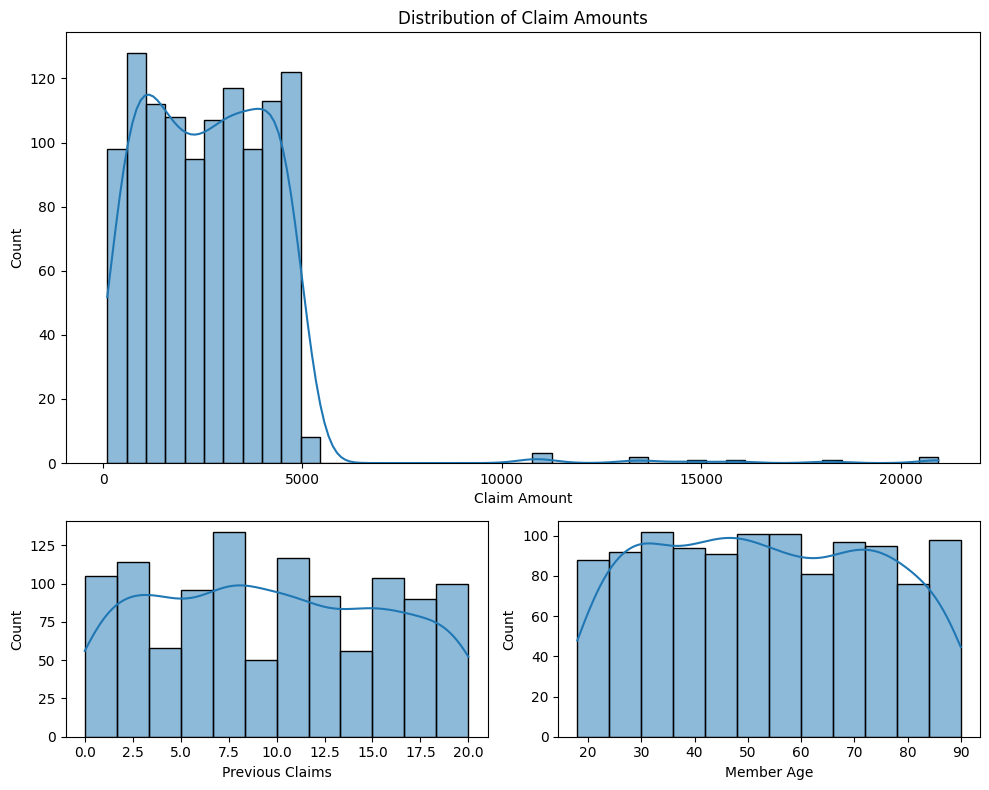

In [52]:
data = df.copy()

# Create a figure
fig = plt.figure(figsize=(10, 8))
sns.histplot(data['Claim Amount'], kde=True, ax=ax1)
plt_1 = ax1.set_title("Distribution of Claim Amounts")

# Create a GridSpec layout: 2 rows, 2 columns (but we'll span the first plot across two columns)
gs = GridSpec(2, 2, height_ratios=[2, 1])  # First row is larger than the second row

# Create the top-center larger plot (spans both columns)
ax1 = fig.add_subplot(gs[0, :])  # This spans the entire first row (top-center)
sns.histplot(data['Claim Amount'], kde=True, ax=ax1)
plt_1 = ax1.set_title("Distribution of Claim Amounts")

# Create the two smaller plots in the second row
ax2 = fig.add_subplot(gs[1, 0])  # Bottom-left
plt_2 = sns.histplot(data['Previous Claims'], kde=True, ax=ax2)


ax3 = fig.add_subplot(gs[1, 1])  # Bottom-right
plt_3 =sns.histplot(data['Member Age'], kde=True, ax=ax3)


# Adjust the layout
plt.tight_layout()
plt.show()

### Findings

The Claims Amount distribution is highly skewed, with the bulk of the data concentrated in the lower range (up to around 5000), after which the number of observations rapidly declines with a few outliers in the higher bins . This pattern suggests that most of the values in the dataset are clustered within the first few bins, with very few high-value outliers.

Previous Claims are fairly uniformly distributed, with some moderate fluctuations in frequency. The data appears balanced, with no extreme skewness or outliers. There might be evidence of clusters around the values

Similar to previous claims, members age appears to be quite evenly distributed, with moderate peaks around 30.0 and 48.0. The spread of data points is fairly consistent without major concentrations or outliers,

### 1.2.2  Correlation Matrix

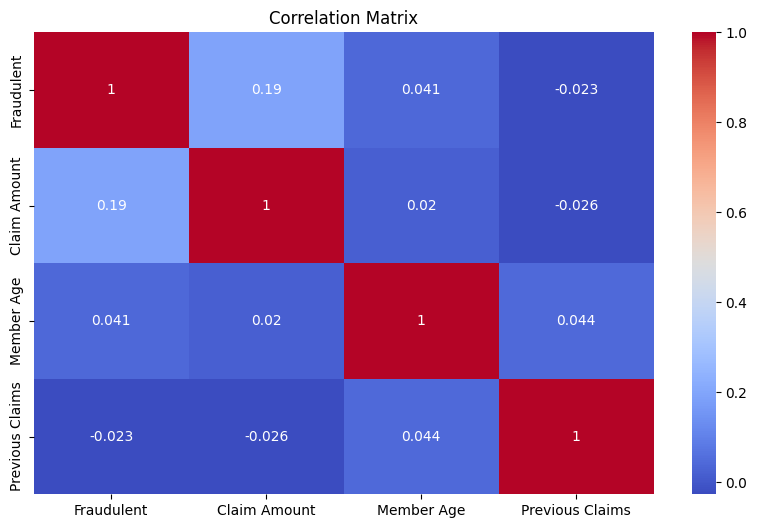

In [39]:
data = df.copy()

corr_colums = ['Fraudulent'] + numeric_columns

# Correlation matrix for numerical features
correlation_matrix = data[corr_colums].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [40]:
correlation_matrix

,Fraudulent,Claim Amount,Member Age,Previous Claims
Fraudulent,1.000000,0.192137,0.041359,-0.022589
Claim Amount,0.192137,1.000000,0.019865,-0.026240
Member Age,0.041359,0.019865,1.000000,0.043520
Previous Claims,-0.022589,-0.026240,0.043520,1.000000


### Interpretation

There is a weak positive correlation of 0.192 between Fraudulent claims and Claim Amount, suggesting that as the claim amount increases, the likelihood of a claim being fraudulent also tends to increase



### 1.2.3 Categorical Values

In [41]:
data = df.copy()

# Encode categorical data
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

# Chi-Square Test for categorical variables
X_cat = data[categorical_columns]
y = data['Fraudulent']
chi_scores = chi2(X_cat, y)
p_values = pd.Series(chi_scores[1], index=X_cat.columns)
print("P-values for each categorical feature:\n", p_values)

P-values for each categorical feature:
 Location    0.001603
dtype: float64


### Interpretation

The p-value of 0.001603 suggests that the feature "Location" has a statistically significant effect on the target variable, implying that location differences are relevant and should be factored into any model or analysis related to this data.

### 1.2.4 Testing for Missing Information

As earlier stated, some variable, defined in the work as `complex_columns`, `identifier_columns` and `date_columns` were removed from the initial analysis above. It is therefore important to test if the is any information that has been removed might affect the predicts of the model. 

We can d this by runnig a **Logistic Regression** model and assessing the significance of the `constant term`

In [42]:
import statsmodels.api as sm

data = df.copy()

data.drop(columns= complex_columns, inplace=True)
data.drop(columns= identifier_columns, inplace=True)
data.drop(columns= date_columns, inplace=True)

# Encode categorical data
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

print(data.columns)

y = data['Fraudulent']
X = data.drop(columns='Fraudulent')
 # Add the intercept
X = sm.add_constant(X) 


# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print(result.summary())


Index(['Claim Amount', 'Previous Claims', 'Member Age', 'Location',
       'Fraudulent'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.261807
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             Fraudulent   No. Observations:                 1116
Model:                          Logit   Df Residuals:                     1111
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Oct 2024   Pseudo R-squ.:                 0.05128
Time:                        08:37:51   Log-Likelihood:                -292.18
converged:                       True   LL-Null:                       -307.97
Covariance Type:            nonrobust   LLR p-value:                 2.322e-06
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

### Interpretation

The above test ist to try and measure the impact of the  unmeasured factors that affect the outcome, i.e other variable other that are not captured by the variables included in the model. In this case this includes, `
```
identifier_columns = ['Claim ID', 'Member ID']
complex_columns = ['Diagnosis Code', 'Procedure Code', 'Provider ID']
date_columns = ['Date of Service', 'Claim Submission Date']
```

The model predicts that, when all the predictor variables are at **zero**, the probability of a claim being fraudulent is about **5.5%**. This suggests that even without taking the predictors into account, the rate for fraud is relatively low in this data. However the output also suggest that the coefficient of **-2.8448** is significant


## 2. Model

Based on the findings from the analysis above a basic mode is constructed with the variables that show signficance. These are the `categorical_columns` including `'Location'` and `numeric_columns` including `'Claim Amount', 'Member Age', 'Previous Claims'`.

In [43]:
# Confusion Matrix comparison for all models
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(15, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## 2.1 Random Forest 1


In [58]:
# Base Random Forest Model
data = df.copy()
base_mod_colums =  categorical_columns + numeric_columns

# Encode categorical data
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

y = data['Fraudulent']
X = data[base_mod_colums]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(np.array(X_train), y_train)


RandomForestClassifier(random_state=42)

### Feature Importance

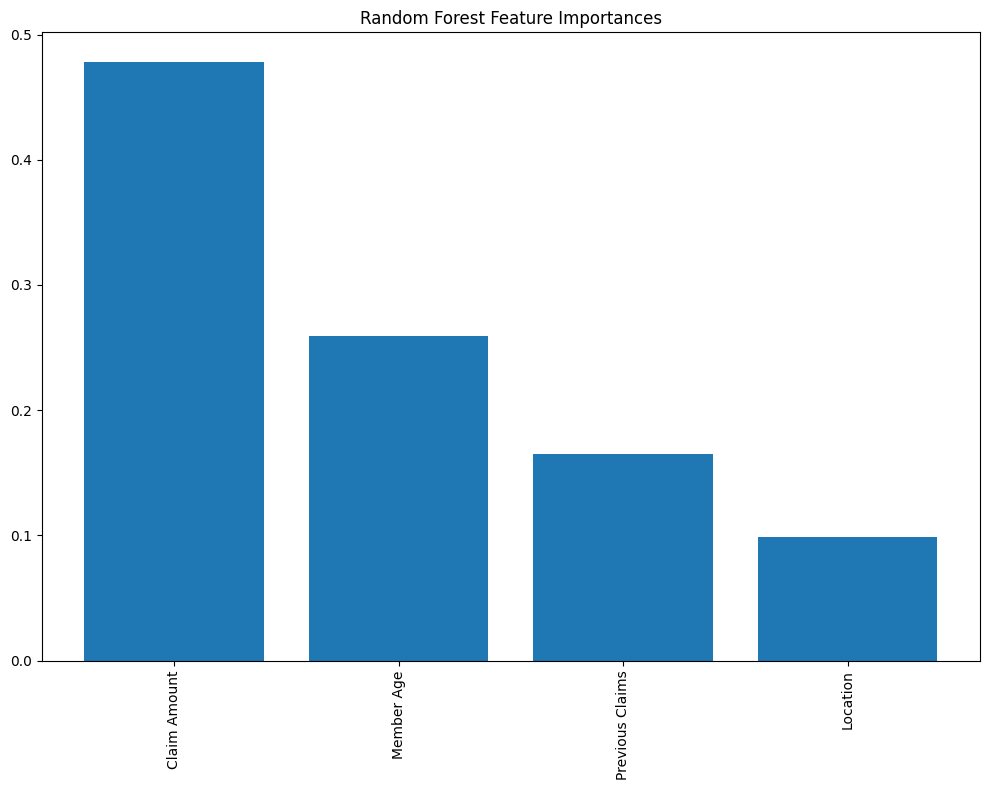

In [59]:
# Feature importance for Random Forest
importances_rf = clf_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.figure(figsize=(10, 8))
plt.title("Random Forest Feature Importances")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()


### Interpretation

 - `Claims Amount` is by far the most important feature in the model, having the largest influence on predicting whether a claim is fraudulent.
 - `Member Age` and `Previous Claims` also have some influence but to a lesser extent.
 - `Location` is the least important feature, contributing the least to the model’s predictions.
 


Random Forest Performance:
Accuracy: 0.9241071428571429
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       204
           1       1.00      0.15      0.26        20

    accuracy                           0.92       224
   macro avg       0.96      0.57      0.61       224
weighted avg       0.93      0.92      0.90       224



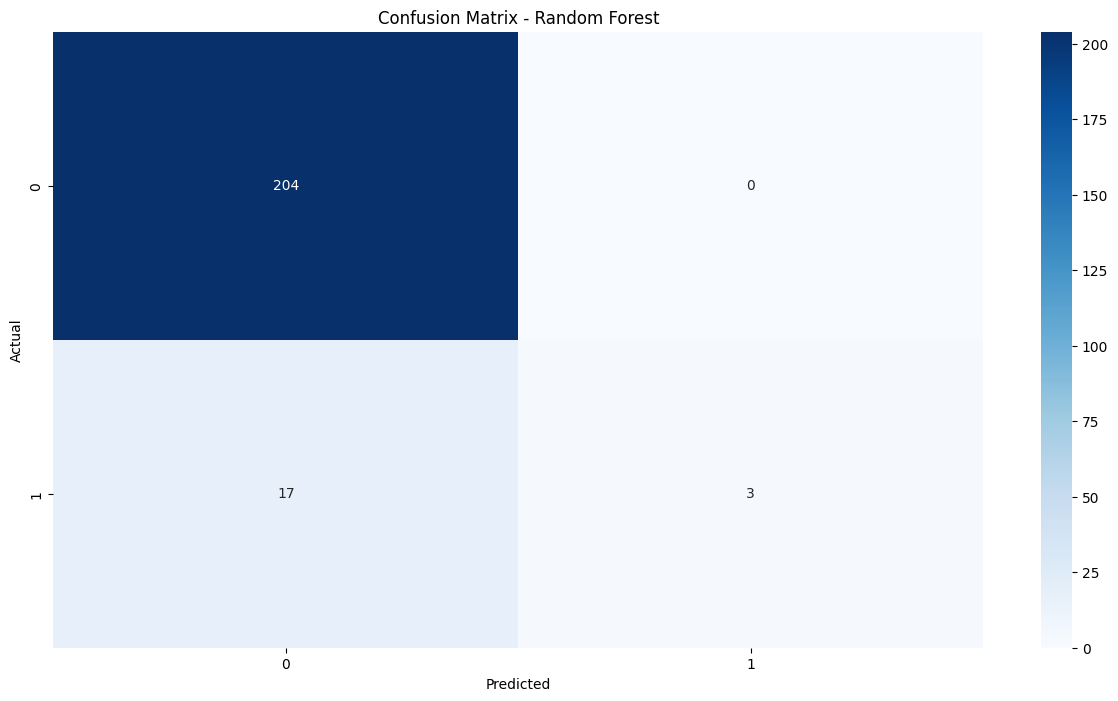

In [46]:
# Evaluate Random Forest
y_pred_rf = clf_rf.predict(np.array(X_test))
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, "Random Forest")

### Model Performance

The model performs extremely well in identifying non-fraudulent claims (class 0), correctly predicting all 204 of the actual non-fraudulent cases (100% recall).For fraudulent claims (class 1), the model shows poor performance in identifying them correctly. Out of 20 actual fraudulent cases, only 3 were correctly identified, leading to very low recall (15%).


**Confusion Matrix**

The confusion matrix shows that the model predicted 204 non-fraudulent claims correctly (true negatives) but misclassified 17 fraudulent cases as non-fraudulent (false negatives). Only 3 fraudulent cases were correctly predicted.

**Macro Average**

The macro average shows the model’s performance across both classes is imbalanced, especially for **class 1 (Fradulent claims)**, where recall and F1-score are very low, indicating poor detection of fraudulent claims.

## 2.2 Random Forest Model 2
### Feature Engineering

Basedon the assumptons listed on the task list i.e.
 - unusually high claim amounts 
 - frequent claim submissions from the same member or provider 
 - patterns that may suggest fraudulent behavior (e.g.,claims for procedures that do not match the diagnosis)
 
we could tae the following actions,

1. Engineer a new feature that marks claims as unusually high compared to the average claim.
2. Creating features that count the number of claims submitted by the same member over a certain period.
3. Creating features that count the number of claims submitted by the same provider over a certain period.



In [60]:
data = df.copy()

# Label encoding
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])


## feature engineering
# setting an expilicit threshold for large amounts
threshold = data['Claim Amount'].mean() + 2 * data['Claim Amount'].std()
data['high_claim_flag'] = data['Claim Amount'] > threshold

data['member_claims_frequency'] = data.groupby('Member ID')['Claim ID'].transform('count')

# Number of claims per provider
data['provider_claims_frequency'] = data.groupby('Provider ID')['Claim ID'].transform('count')



# Selecting target and features
y = data['Fraudulent']
X = data[['Claim Amount', 'high_claim_flag', 'member_claims_frequency', 'provider_claims_frequency', 'Previous Claims', 'Member Age', 'Location']]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# classifier
clf_rf2 = RandomForestClassifier(random_state=42)
clf_rf2.fit(np.array(X_train), y_train)


RandomForestClassifier(random_state=42)

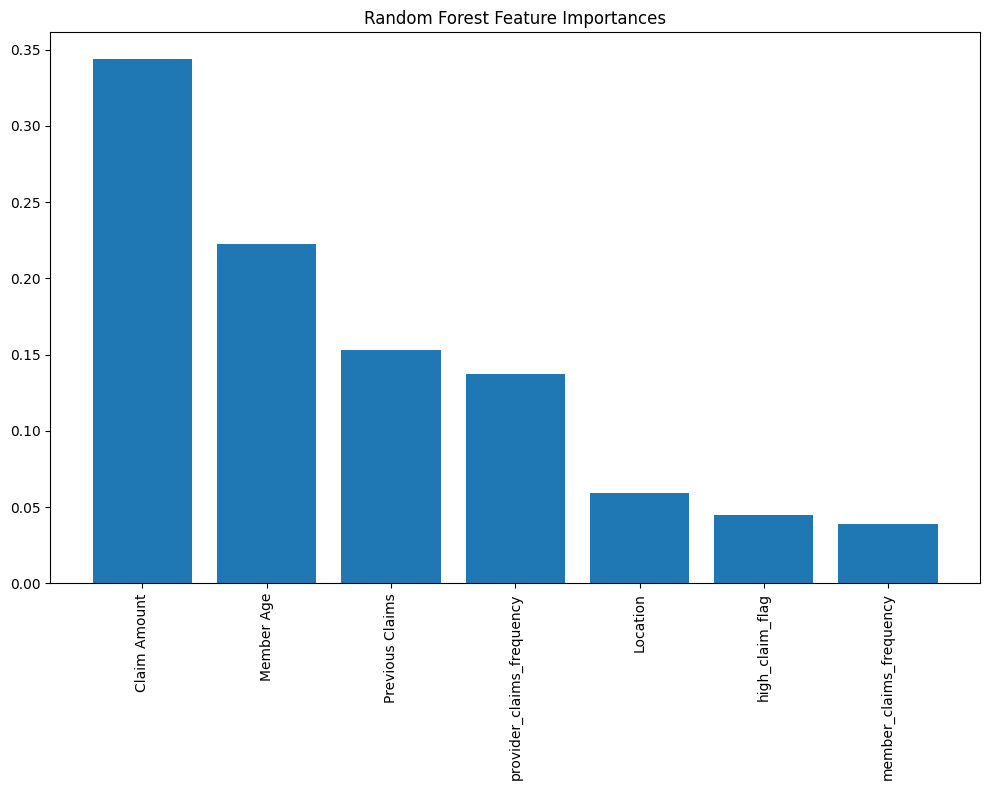

In [61]:
# Feature importance for Random Forest
importances_rf = clf_rf2.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.figure(figsize=(10, 8))
plt.title("Random Forest Feature Importances")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

### Interpretation

The added features did not suppass the informationth that `Claims Amount`, `Member Age` and `Previus Claims` add to the model.

Random Forest Performance:
Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       204
           1       0.83      0.25      0.38        20

    accuracy                           0.93       224
   macro avg       0.88      0.62      0.67       224
weighted avg       0.92      0.93      0.91       224



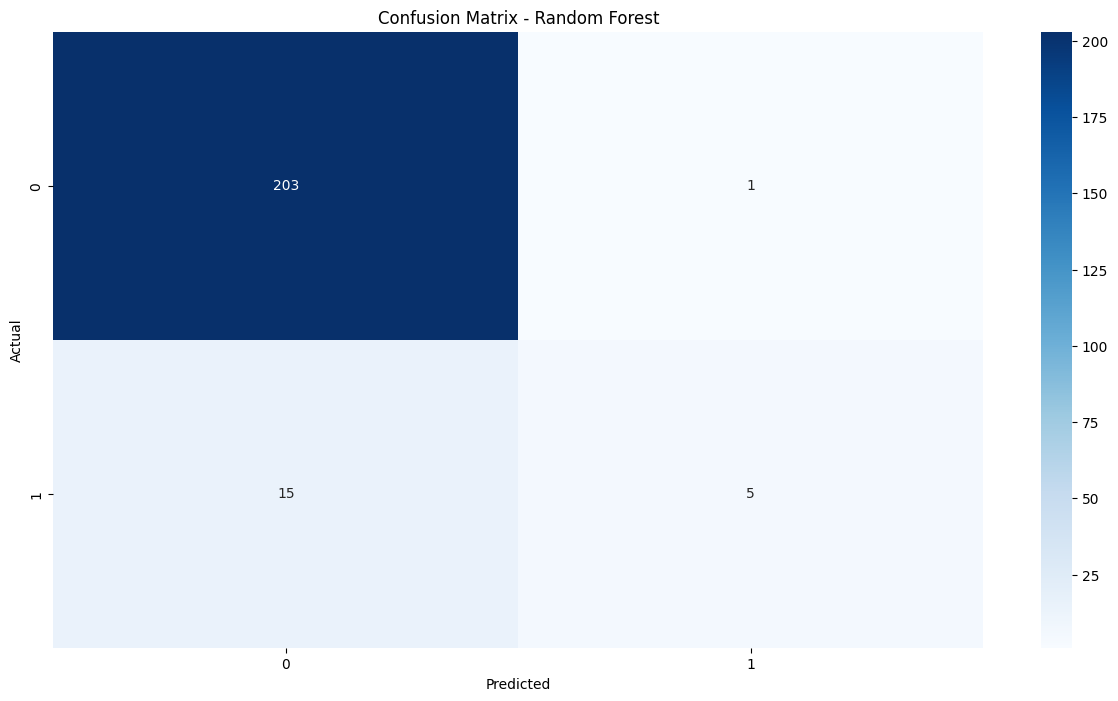

In [49]:
# Evaluate Random Forest
y_pred_rf = clf_rf2.predict(np.array(X_test))
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, "Random Forest")

### Model Performance and Evaluation

Similar to the basic model, the second model performs very well in identifying non-fraudulent claims (class 0), with only 1 non-fraudulent case misclassified.It however performs slightly better than the first in identifying fraudulent claims. It correctly identified 5 out of 20 fraudulent cases (25% recall), which is an improvement over the first model.

**Confusion Matrix**

The second model correctly classified 203 non-fraudulent claims (true negatives) and 5 fraudulent claims (true positives). It misclassified 15 fraudulent claims as non-fraudulent (false negatives).

**Macro Average**

The macro average indicates a better balance in performance across both fradulent and non-fradulent claims. Notably the model has improved in classifying fradulent claims, where recall and F1-score are higher compared to the first model.

## 3. Risk Scoring

The risk score assigned to each claim is a direct reflection of the likelihood that the claim is fraudulent, wasteful, or abusive. Claims that exhibit characteristics typically associated with FWA (e.g., unusually high claim amounts, member age, previous claim submissions ) will receive higher scores. This is as seen in the feature importance associated with the model.



In [50]:
# Risk Scoring

# Random Forest Model
data = df.copy()
base_mod_colums =  categorical_columns + numeric_columns

# Encode categorical data
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

y = data['Fraudulent']
X = data[base_mod_colums]

data['risk_score'] = clf_rf.predict_proba(np.array(X))[:, 1]
print('Top 10 Riskiest Claims - Random Forest 1')
print(data[['Claim Amount', 'risk_score', 'Member Age', 'Previous Claims']].sort_values(by='risk_score', ascending=False).head(10),end = '\n\n')

Top 10 Riskiest Claims - Random Forest 1
    Claim Amount  risk_score  Member Age  Previous Claims
65  10797.161198        1.00          56                6
93  20859.397337        0.98          56               10
36  18194.379458        0.97          50                5
69  13617.285213        0.96          31                7
33  20950.622791        0.96          79                8
84  15883.243175        0.96          60                0
80  14751.498824        0.95          51                3
82  13269.988310        0.94          71                2
81  11070.517470        0.92          41                0
17  10777.635750        0.91          48                8



In [51]:
# Risk Scoring
data = df.copy()

# Label encoding
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])


## feature engineering
# setting an expilicit threshold for large amounts
threshold = data['Claim Amount'].mean() + 2 * data['Claim Amount'].std()
data['high_claim_flag'] = data['Claim Amount'] > threshold

data['member_claims_frequency'] = data.groupby('Member ID')['Claim ID'].transform('count')

# Number of claims per provider
data['provider_claims_frequency'] = data.groupby('Provider ID')['Claim ID'].transform('count')

# Selecting target and features
y = data['Fraudulent']
X = data[['Claim Amount', 'high_claim_flag', 'member_claims_frequency', 'provider_claims_frequency', 'Previous Claims', 'Member Age', 'Location']]


data['risk_score'] = clf_rf2.predict_proba(np.array(X))[:, 1]
print('Top 10 Riskiest Claims - Random Forest 2')
print(data[['Claim Amount', 'risk_score', 'Member Age', 'Previous Claims']].sort_values(by='risk_score', ascending=False).head(10),end = '\n\n')

Top 10 Riskiest Claims - Random Forest 2
    Claim Amount  risk_score  Member Age  Previous Claims
84  15883.243175        1.00          60                0
65  10797.161198        1.00          56                6
93  20859.397337        1.00          56               10
81  11070.517470        0.98          41                0
69  13617.285213        0.97          31                7
36  18194.379458        0.97          50                5
82  13269.988310        0.96          71                2
33  20950.622791        0.96          79                8
17  10777.635750        0.94          48                8
0    3699.420000        0.92          54                4



The purpose of risk scoring would be:

1. **Actionable Prioritization**:
   - The score enables automated triage of claims, where high-risk claims are flagged for immediate investigation.
   - Moderate-risk claims might warrant further review or monitoring, and low-risk claims can be processed with minimal intervention.
   
2. **Thresholds for Efficient Investigation**:
   - The use of thresholds allows investigators to focus their efforts on claims most likely to result in cost savings if found to be fraudulent.
   - This minimizes the number of false positives and optimizes the resource allocation of the investigation teams.
   
NB: Based on the threshold, risk categories such as `High`, `Moderate` and `Low` could be defined in order to determine the necessary intervention at a human level i.e. `Urgent Investigation`, `Review or Monitoring` and `Normal` respectively


## 4. Recommendation for Improvement & Deployment



 - Focus on improving the recall of fraud cases for better fraud flagging performance
 - If possible add more fields in order to add information to the model
 - Continuous Monitoring and Updates which include implement early-warning systems that trigger if the model’s performance starts to degrade
 - Regular fraud detection updates